# Introduction to Video Understanding

## Instrucciones Generales

El siguiente práctico se puede realizar de manera **individual**. El formato de entregar es el **archivo .ipynb con todas las celdas ejecutadas**. Todas las preguntas deben ser respondida en celdas de texto. No se aceptará el _output_ de una celda de código como respuesta.

**Nombre:** FRANCISCO MENA

**Fecha de entrega: Viernes 23 de Abril.**

El siguiente práctico cuanta con 2 secciones donde cada una contendrá 1 o más actividades a realizar. Algunas actividades correspondrán a escribir código y otras a responder preguntas. 

**Importante.** Para facilitar su ejecución, cada sección puede ser ejecutada independientemente.

Se recomienda **fuertemente** revisar las secciones donde se entrega código porque algunas actividades de código pueden reutilizar el mismo código pero con cambios en algunas líneas.

## 1. Utilities

Essential libraries for executing this tutorial.

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 4.3MB/s 


In [2]:
import os, cv2
from tqdm.notebook import tqdm
import re
import math
import numpy as np
import torch.utils.data as data
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import torchvision

from tensorflow_docs.vis import embed
from moviepy.editor import *

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2351104/45929032 bytes (5.1%)5824512/45929032 bytes (12.7%)9076736/45929032 bytes (19.8%)12582912/45929032 bytes (27.4%)15998976/45929032 bytes (34.8%)19660800/45929032 bytes (42.8%)23191552/45929032 bytes (50.5%)26804224/45929032 bytes (58.4%)30220288/45929032 bytes (65.8%)33505280/45929032 bytes (73.0%)37011456/45929032 bytes (80.6%)40460288/45929032 bytes (88.1%)

## 2. Dataset

### Download data

We will use the [UCF11 dataset](https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php) consisting of YouTube videos containing 11 action categories. For this tutorial, the dataset is hosted in a repository that we own.

In [3]:
!gdown --id 1cC905lSV9-rMiVKR2WwrCHN_kfpRBAyT

Downloading...
From: https://drive.google.com/uc?id=1cC905lSV9-rMiVKR2WwrCHN_kfpRBAyT
To: /content/UCF11_updated_mpg.rar
1.05GB [00:13, 77.4MB/s]


In [4]:
!unrar x '/content/UCF11_updated_mpg.rar'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/UCF11_updated_mpg.rar

Creating    UCF11_updated_mpg                                         OK
Creating    UCF11_updated_mpg/basketball                              OK
Creating    UCF11_updated_mpg/basketball/v_shooting_01                OK
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_01.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_02.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_03.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_04.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_05.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_06.mpg       0%  OK 
Extracting  UCF11_updated_mpg/basketball/v_shooting_01/v_shooting_01_0

### Exploring data

Let's explore the basic statistics of the dataset.

In [5]:
def statistics(path_dataset):
  classes = os.listdir(path_dataset)
  num_classes = len(classes)
  dictionary = {}
  for name in classes:
    num_videos = len(os.listdir("{}/{}".format(path_dataset,name)))-1
    total_videos = len(os.listdir("{}/{}/Annotation".format(path_dataset,name)))
    dictionary[name] = {'unique_videos': num_videos, 'total_videos': total_videos}
  return dictionary

In [6]:
path_dataset = "/content/UCF11_updated_mpg"
out = statistics(path_dataset)
pd.DataFrame.from_dict(out)

soccer_juggling  ...  volleyball_spiking
unique_videos               25  ...                  25
total_videos               156  ...                 109

[2 rows x 11 columns]

### Visualize Videos

Here we can visualize a selected video from the dataset.

In [7]:
def to_gif(path, duration):
  clip = (VideoFileClip(path).subclip((0),(duration)).resize(0.75))
  clip.write_gif("output.gif")
  return embed.embed_file("output.gif")


[MoviePy] Building file output.gif with imageio


100%|██████████| 60/60 [00:04<00:00, 13.84it/s]



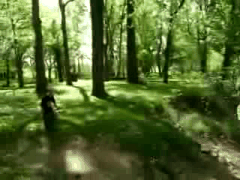

In [8]:
path_sample = "/content/UCF11_updated_mpg/swing/v_swing_01/v_swing_01_01.mpg"
to_gif(path_sample, 2)

### Preprocess data

Here we have two main functions for preprocess the videos.

The `vids_to_frames` function convert from video in mpg formart to N frames in jpg format.

In [9]:
def vids_to_frames(path_videos, action, path):
    path_action = os.path.join(path_videos, action)
    list_cams = os.listdir(path_action)
    for cam in list_cams:
        path_cam_save = os.path.join(path, cam.split('.')[0])
        os.mkdir(path_cam_save)
        vid_path = os.path.join(path_action, cam)
        vidcap = cv2.VideoCapture(vid_path)
        success,image = vidcap.read()
        count = 0
        while success:
            path_cam_frame = os.path.join(path_cam_save, f'frame_{count}.jpg')
            cv2.imwrite(path_cam_frame, image)
            success,image = vidcap.read()
            count += 1

The `preprocess_data` function divides the data into train and val, and separate the videos into frames using the vids_to_frames function.

We need to define the `paths` and `split_size`.

In [10]:
def preprocess_data(path_data, train_path, val_path, split_size):
    if not os.path.exists(train_path) and not os.path.exists(val_path): 
        os.mkdir(train_path) 
        os.mkdir(val_path)
        list_classes = os.listdir(path_data)
        for class_name in tqdm(list_classes):
            train_class = os.path.join(train_path, class_name)
            os.mkdir(train_class) 
            val_class = os.path.join(val_path, class_name)
            os.mkdir(val_class) 
            path_videos = os.path.join(path_data, class_name)
            list_actions = os.listdir(path_videos)
            list_actions = [a for a in list_actions if a != 'Annotation']
            num_actions = len(list_actions)
            num_actions_train = int(num_actions*split_size)
            action_train = list_actions[:num_actions_train]
            action_test = list_actions[num_actions_train:]
            for action in list_actions:
                if action in action_train:
                    vids_to_frames(path_videos, action, train_class)
                else: 
                    vids_to_frames(path_videos, action, val_class)

Defining the paths to training data and validation data. Then we preprocess the whole dataset with `split_size=0.8`

In [11]:
path_data = '/content/UCF11_updated_mpg'
train_path = '/content/train'
val_path = '/content/val'

In [12]:
preprocess_data(path_data, train_path, val_path, 0.8) # it takes about ~8min

### Video dataset

Now, we will create our dataset for UCF11 dataset. It is necessary to define a fixed `input_size`, and normalization parameters (`input_mean` and `input_std`).

We will use a Resnet-34 architecture in this tutorial.

In [13]:
# name of architecture
arch = 'Resnet' # Resnet-34
# size of frame
input_size = 224
# normalization
input_mean = [0.485, 0.456, 0.406]
input_std = [0.229, 0.224, 0.225]

This is the Dataset Class created to transform and load the videos into the model using uniform temporal sampling. Note that `np.linspace` function allows to do that. 

<figure>
<center>
<img src='https://vrzkj25a871bpq7t1ugcgmn9-wpengine.netdna-ssl.com/wp-content/uploads/2018/10/visual-representation-of-np-linspace-0-100-5.png' width="500" />
</center>
</figure>

In [14]:
class VideoDataset(data.Dataset):

    def __init__(self, path_data, num_frames, transform=None):
        # This code loads all the videos and prepares the labels.
        self.list_classes = os.listdir(path_data)
        self.list_data = []
        self.list_labels = []
        for idx, c in enumerate(self.list_classes):
            path_class_data = os.path.join(path_data, c)
            class_data = os.listdir(path_class_data)
            self.list_data.extend(class_data)
            self.list_labels.extend([idx]*len(class_data))
        self.root_dir = path_data
        self.transform = transform
        self.num_frames = num_frames

    def __len__(self):
        # The number of all videos in the set
        return len(self.list_data)

    def natural_keys(self, text):
        return int(re.split(r'(\d+)', text)[1])

    def __getitem__(self, idx):
        # function to get the item or video i
        elem = self.list_data[idx]
        label = self.list_labels[idx]
        path_elem = os.path.join(self.root_dir, self.list_classes[label], elem)
        frames_elem = os.listdir(path_elem)
        frames_elem.sort(key=self.natural_keys)
        idx_frames = np.linspace(0, len(frames_elem)-1, num=self.num_frames, dtype = int)
        list_frames = []
        for ind_frame in idx_frames:
            frame_name = frames_elem[ind_frame]
            img_name = os.path.join(path_elem, frame_name)
            frame = Image.open(img_name).convert('RGB')
            list_frames.append(frame)
        process_data = self.transform(list_frames)
        return process_data, label

### Video transformation

These classes and functions are used to augment the video data, which is essential to train the model and avoid overfitting.

In [15]:
class GroupRandomHorizontalFlip(object):
    """Randomly horizontally flips the given PIL.Image with a probability of 0.5
    """
    def __init__(self, is_flow=False):
        self.is_flow = is_flow

    def __call__(self, img_group, is_flow=False):
        v = random.random()
        if v < 0.5:
            ret = [img.transpose(Image.FLIP_LEFT_RIGHT) for img in img_group]
            if self.is_flow:
                for i in range(0, len(ret), 2):
                    ret[i] = ImageOps.invert(ret[i])  # invert flow pixel values when flipping
            return ret
        else:
            return img_group

In [16]:
class GroupMultiScaleCrop(object):

    def __init__(self, input_size, scales=None, max_distort=1, fix_crop=True, more_fix_crop=True):
        self.scales = scales if scales is not None else [1, .875, .75, .66]
        self.max_distort = max_distort
        self.fix_crop = fix_crop
        self.more_fix_crop = more_fix_crop
        self.input_size = input_size if not isinstance(input_size, int) else [input_size, input_size]
        self.interpolation = Image.BILINEAR

    def __call__(self, img_group):

        im_size = img_group[0].size

        crop_w, crop_h, offset_w, offset_h = self._sample_crop_size(im_size)
        crop_img_group = [img.crop((offset_w, offset_h, offset_w + crop_w, offset_h + crop_h)) for img in img_group]
        ret_img_group = [img.resize((self.input_size[0], self.input_size[1]), self.interpolation)
                         for img in crop_img_group]
        return ret_img_group

    def _sample_crop_size(self, im_size):
        image_w, image_h = im_size[0], im_size[1]

        # find a crop size
        base_size = min(image_w, image_h)
        crop_sizes = [int(base_size * x) for x in self.scales]
        crop_h = [self.input_size[1] if abs(x - self.input_size[1]) < 3 else x for x in crop_sizes]
        crop_w = [self.input_size[0] if abs(x - self.input_size[0]) < 3 else x for x in crop_sizes]

        pairs = []
        for i, h in enumerate(crop_h):
            for j, w in enumerate(crop_w):
                if abs(i - j) <= self.max_distort:
                    pairs.append((w, h))

        crop_pair = random.choice(pairs)
        if not self.fix_crop:
            w_offset = random.randint(0, image_w - crop_pair[0])
            h_offset = random.randint(0, image_h - crop_pair[1])
        else:
            w_offset, h_offset = self._sample_fix_offset(image_w, image_h, crop_pair[0], crop_pair[1])

        return crop_pair[0], crop_pair[1], w_offset, h_offset

    def _sample_fix_offset(self, image_w, image_h, crop_w, crop_h):
        offsets = self.fill_fix_offset(self.more_fix_crop, image_w, image_h, crop_w, crop_h)
        return random.choice(offsets)

    @staticmethod
    def fill_fix_offset(more_fix_crop, image_w, image_h, crop_w, crop_h):
        w_step = (image_w - crop_w) // 4
        h_step = (image_h - crop_h) // 4

        ret = list()
        ret.append((0, 0))  # upper left
        ret.append((4 * w_step, 0))  # upper right
        ret.append((0, 4 * h_step))  # lower left
        ret.append((4 * w_step, 4 * h_step))  # lower right
        ret.append((2 * w_step, 2 * h_step))  # center

        if more_fix_crop:
            ret.append((0, 2 * h_step))  # center left
            ret.append((4 * w_step, 2 * h_step))  # center right
            ret.append((2 * w_step, 4 * h_step))  # lower center
            ret.append((2 * w_step, 0 * h_step))  # upper center

            ret.append((1 * w_step, 1 * h_step))  # upper left quarter
            ret.append((3 * w_step, 1 * h_step))  # upper right quarter
            ret.append((1 * w_step, 3 * h_step))  # lower left quarter
            ret.append((3 * w_step, 3 * h_step))  # lower righ quarter

        return ret

In [17]:
class GroupScale(object):
    """ Rescales the input PIL.Image to the given 'size'.
    'size' will be the size of the smaller edge.
    For example, if height > width, then image will be
    rescaled to (size * height / width, size)
    size: size of the smaller edge
    interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        self.worker = torchvision.transforms.Scale(size, interpolation)

    def __call__(self, img_group):
        return [self.worker(img) for img in img_group]


class GroupCenterCrop(object):
    def __init__(self, size):
        self.worker = torchvision.transforms.CenterCrop(size)

    def __call__(self, img_group):
        return [self.worker(img) for img in img_group]


class Stack(object):

    def __init__(self, roll=False):
        self.roll = roll

    def __call__(self, img_group):
        if img_group[0].mode == 'L':
            return np.concatenate([np.expand_dims(x, 2) for x in img_group], axis=2)
        elif img_group[0].mode == 'RGB':
            if self.roll:
                return np.concatenate([np.array(x)[:, :, ::-1] for x in img_group], axis=2)
            else:
                return np.concatenate(img_group, axis=2)


class ToTorchFormatTensor(object):
    """ Converts a PIL.Image (RGB) or numpy.ndarray (H x W x C) in the range [0, 255]
    to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] """

    def __init__(self, div=True):
        self.div = div

    def __call__(self, pic):
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic).permute(2, 0, 1).contiguous()
        else:
            # handle PIL Image
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
            img = img.view(pic.size[1], pic.size[0], len(pic.mode))
            # put it from HWC to CHW format
            # yikes, this transpose takes 80% of the loading time/CPU
            img = img.transpose(0, 1).transpose(0, 2).contiguous()
        return img.float().div(255) if self.div else img.float()


class GroupNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        rep_mean = self.mean * (tensor.size()[0] // len(self.mean))
        rep_std = self.std * (tensor.size()[0] // len(self.std))

        # TODO: make efficient
        for t, m, s in zip(tensor, rep_mean, rep_std):
            t.sub_(m).div_(s)

        return tensor


def get_transform():
    cropping = torchvision.transforms.Compose([
        GroupScale(256),
        GroupCenterCrop(224),
    ])
    transform = torchvision.transforms.Compose([
        cropping,
        Stack(roll=False),
        ToTorchFormatTensor(div=True),
        GroupNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transform

def scale_size(input_size):
    return input_size * 256 // 224

## 3. Dataloader

### Instance transformation

Instantiate the transformations for training and validation

In [18]:
transform_train = torchvision.transforms.Compose([
                                                  GroupMultiScaleCrop(input_size, [1, .875, .75, .66]),
                                                  GroupRandomHorizontalFlip(is_flow=False), 
                                                  Stack(roll=(arch in ['BNInception', 'InceptionV3'])),
                                                  ToTorchFormatTensor(div=(arch not in ['BNInception', 'InceptionV3'])),
                                                  GroupNormalize(input_mean, input_std)
                                                  ])

In [19]:
transform_val = torchvision.transforms.Compose([
                       GroupScale(int(scale_size(input_size))),
                       GroupCenterCrop(input_size),
                       Stack(roll=(arch in ['BNInception', 'InceptionV3'])),
                       ToTorchFormatTensor(div=(arch not in ['BNInception', 'InceptionV3'])),
                       GroupNormalize(input_mean, input_std)
                   ])

### Instance video dataset

Instantiate the VideoDataset for training and validation with 8 frames per video

In [20]:
num_frames = 8

In [21]:
dataset_train = VideoDataset('/content/train', num_frames, transform_train)
dataset_val = VideoDataset('/content/val', num_frames, transform_val)

## 4. Create model

This is the model used to classify the videos. It is based on a ResNet-34 backbone and avg pooling to reduce the temporal dimension

In [22]:
class VideoNet(nn.Module):
    def __init__(self, num_classes, num_segments=8):
        super(VideoNet, self).__init__()
        self.net = models.resnet34(pretrained=True)
        self.fc = nn.Linear(self.net.fc.in_features, num_classes)
        self.num_segments = num_segments
        self.net.fc = nn.Identity()

    def forward(self, inputs):
        inputs = inputs.view((-1, 3) + inputs.size()[-2:])
        out = self.net(inputs)
        out = out.view((-1, self.num_segments) + out.size()[1:])
        out = torch.mean(out, dim = 1)
        out = self.fc(out)
        return out

### Instance model

Instantiate the model

In [23]:
num_classes = len(dataset_train.list_classes)
model = VideoNet(num_classes, num_frames)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


## 5. Train the model

Train the model during 12 epoch

In [24]:
num_epochs = 3

In [25]:
device = torch.device("cuda")
model = model.to(device)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [27]:
batch_size = 40

trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

dataloaders={'train': trainloader, 'val':testloader}
dataset_sizes = {'train': len(dataset_train), 'val': len(dataset_val)}

In [28]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    dict_acc = {'train': [], 'val': []}
    dict_loss = {'train': [], 'val': []}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            num_elem = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, dim = 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_elem += inputs.size(0)
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / num_elem
            epoch_acc = running_corrects.double() / num_elem

            dict_acc[phase].append(epoch_acc)
            dict_loss[phase].append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_acc, dict_loss

In [29]:
model, dict_acc, dict_loss = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/2
----------
train Loss: 1.9143 Acc: 0.4359
val Loss: 1.2879 Acc: 0.6844

Epoch 1/2
----------
train Loss: 1.0439 Acc: 0.7812
val Loss: 0.8233 Acc: 0.7594

Epoch 2/2
----------
train Loss: 0.6542 Acc: 0.8844
val Loss: 0.6306 Acc: 0.8219

Training complete in 7m 23s
Best val Acc: 0.821875


## 6. Train Graphs

In [30]:
def parse_data(data):
    new_data = []
    for d in data:
        new_data.append(d.item())
    return new_data

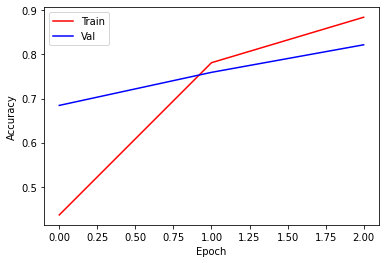

In [31]:
epochs = list(range(num_epochs))
plt.plot(epochs, parse_data(dict_acc['train']), 'r', label='Train')
plt.plot(epochs, parse_data(dict_acc['val']), 'b', label='Val')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 7. Positive and Negative examples 

In [32]:
def getInferenceModel(model, testloader):
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim = 1)
        break
    return preds, inputs, labels

In [33]:
def plot_example(dataset, idx, pred):

    fig=plt.figure(figsize=(20, 8))
    columns = 4
    rows = 2
    elem = dataset.list_data[idx]
    label = dataset.list_labels[idx]
    fig.suptitle('GT: {}, P: {}'.format(dataset.list_classes[label], dataset.list_classes[pred]), fontsize=16)
    path_elem = os.path.join(dataset.root_dir, dataset.list_classes[label], elem)
    frames_elem = os.listdir(path_elem)
    frames_elem.sort(key=dataset.natural_keys)
    idx_frames = np.linspace(0, len(frames_elem)-1, num=dataset.num_frames, dtype = int)
    list_frames = []
    for i, ind_frame in enumerate(idx_frames):
        frame_name = frames_elem[ind_frame]
        img_name = os.path.join(path_elem, frame_name)
        frame = Image.open(img_name).convert('RGB')
        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title("t = {}".format(ind_frame))
        ax.axis('off')
        plt.imshow(frame)

In [34]:
model.eval()
testloader = torch.utils.data.DataLoader(dataset_val, batch_size=40, shuffle=False)

In [35]:
preds, inputs, labels = getInferenceModel(model, testloader)

In [36]:
good_examples = np.where((preds == labels).cpu() == True)[0]
good_examples

array([ 1,  3,  8,  9, 18, 21, 23, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39])

In [37]:
bad_examples = np.where((preds != labels).cpu() == True)[0]
bad_examples

array([ 0,  2,  4,  5,  6,  7, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22,
       24, 25, 26, 27])

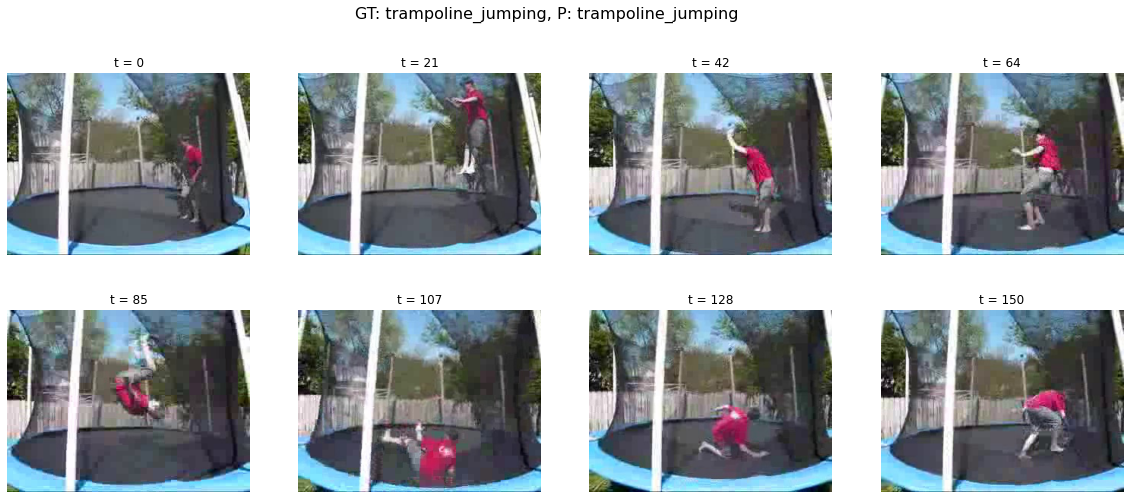

In [38]:
idx = good_examples[9]
plot_example(dataset_val, idx, preds[idx])

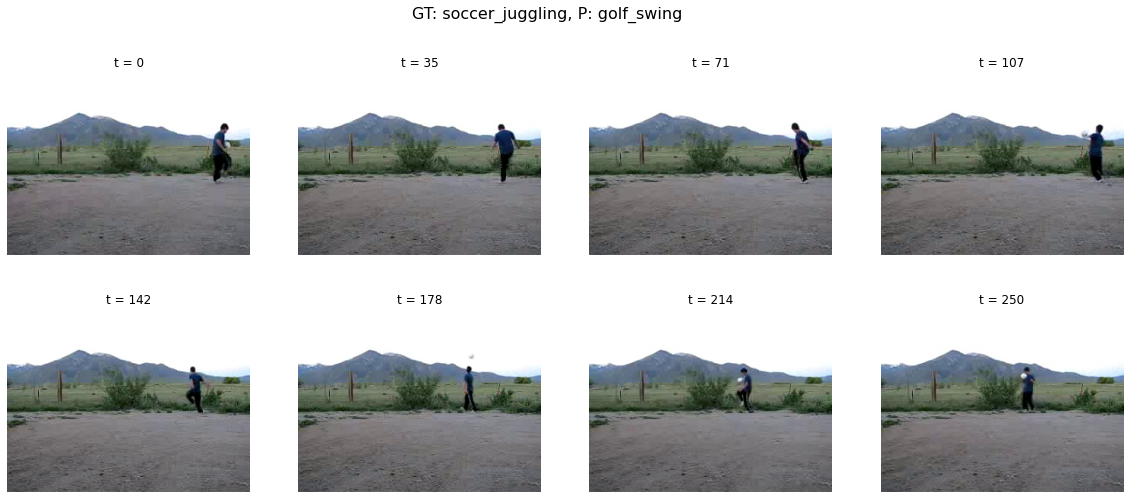

In [39]:
idx = bad_examples[0]
plot_example(dataset_val, idx, preds[idx])

## 8. Activity


In this section, you will be asked about the topics studied in the theoretical and practical class.

1. What are the main challenges of video analysis?

**RESPUESTA 1** Los principales desafios de analisis de video:
- La sequencia temporal de un video es importante tomar en cuenta, hay un orden en las imagenes de un video. 

- Multimodalidad, es decir, ademas de sequencia de imagenes, tiene audio, y a veces subtitulos.

- El tamaño de un archivo de video requiere más recursos que simplemente analizar imagenes


2. Why is video analysis important?

**RESULTADO 2**  Es importante para multiples usos, por ej., camaras de seguridad, deteccion de textos, automatizar tareas que usan video, explorar el mundo (autos inteligentes, drones), etc. Es decir, hay muchas tareas que usan video, y el video analisis con machine learning abre muchas oportunidades. 

3. What is action classification?

**RESPUESTA 3**  Action classification es usar un modelo para predecir la etiqueta de la o acción (o acciones) que ocurre en un video 

4. Mention and describe the temporal sampling used in this tutorial 

**RESPUESTA 4** Ya que usar todos los frames de un video sería demasiada información, se samplea un número definido de frames para usar en el modelo. De esta manera, se retiene la información importante del video, evitando tener que manejar demasiada información. En este tutorial se implementa el sampling al elegir el número de frames a usar de un video.

5. What is the temporal pooling followed in this lab? What are the problems with it?

**RESPUESTA 5** Para el temporal pooling el modelo usa un promedio de las distintas representaciones de los frames , y el problema es que no toma en cuenta el orden de las imagenes, el modelo no tendrá conocimiento del orden sequencial de los frames.

6. Train and evaluate the model with 4 frames per video instead of 8 frames. How does the model performance be affected? Note: Use code of section 6 to show the training graph.

In [41]:
num_frames = 4
dataset_train = VideoDataset('/content/train', num_frames, transform_train)
dataset_val = VideoDataset('/content/val', num_frames, transform_val)

In [42]:
num_classes = len(dataset_train.list_classes)
model = VideoNet(num_classes, num_frames)

In [43]:
device = torch.device("cuda")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [44]:
batch_size = 40

trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

dataloaders={'train': trainloader, 'val':testloader}
dataset_sizes = {'train': len(dataset_train), 'val': len(dataset_val)}

In [45]:
model, dict_acc, dict_loss = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/2
----------
train Loss: 1.9076 Acc: 0.4211
val Loss: 1.3853 Acc: 0.6156

Epoch 1/2
----------
train Loss: 1.0593 Acc: 0.7938
val Loss: 0.8484 Acc: 0.7656

Epoch 2/2
----------
train Loss: 0.6422 Acc: 0.8852
val Loss: 0.6550 Acc: 0.8000

Training complete in 3m 46s
Best val Acc: 0.800000


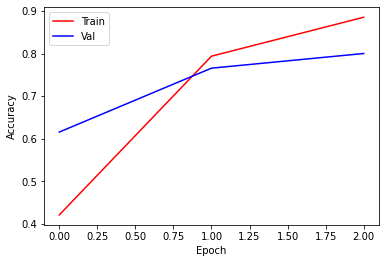

In [46]:
epochs = list(range(num_epochs))
plt.plot(epochs, parse_data(dict_acc['train']), 'r', label='Train')
plt.plot(epochs, parse_data(dict_acc['val']), 'b', label='Val')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**RESPUESTA** Al entrenar el modelo con 4 frames en vez de 8, se observa que el accuracy es levemente menor, además de que el accuracy del modelo tiene una inflexión en la primera epoca y no crece tan rápido como el modelo con 8 frames. 

Por lo tanto, seobserva que con 8 frames el modelo tiene un mejor performance, lo cual es razonable ya que le estamos dando más información al modelo. 